In [1]:
import pandas as pd
import numpy as np
from typing import Union

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import sys
sys.path.append('..')
from pyRothC.RothC import RothC
np.set_printoptions(precision=3,suppress=True )

## Main part

\begin{aligned}
& \frac{d \boldsymbol{C}}{\mathrm{d} t}=I\left(\begin{array}{c}
\gamma \\
1-\gamma \\
0 \\
0 \\
0
\end{array}\right) 
 +\left(\begin{array}{ccccc}
-k_1 & 0 & 0 & 0 & 0 \\
0 & -k_2 & 0 & 0 & 0 \\
a_{3,1} & a_{3,2} & -k_3+a_{3,3} & a_{3,4} & 0 \\
a_{4,1} & a_{4,2} & a_{4,3} & -k_4+a_{4,4} & 0 \\
0 & 0 & 0 & 0 & 0
\end{array}\right)\left(\begin{array}{l}
C_1 \\
C_2 \\
C_3 \\
C_4 \\
C_5
\end{array}\right) \\
&
\end{aligned}

In [2]:
Temp=np.array([-0.4, 0.3, 4.2, 8.3, 13.0, 15.9,18.0, 17.5, 13.4, 8.7, 3.9,  0.6])
Precip=np.array([49, 39, 44, 41, 61, 58, 71, 58, 51,48, 50, 58])
Evp=np.array([12, 18, 35, 58, 82, 90, 97, 84, 54, 31,14, 10])

soil_thick=25  #Soil thickness (organic layer topsoil), in cm
SOC=69.7       #Soil organic carbon in Mg/ha 
clay=48        #Percent clay
Cinputs=2.7   #Annual C inputs to soil in Mg/ha/yr


rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48,
             input_carbon=Cinputs,
             pE=1.0,
             C0=[0, 0, 0, 0, 2.7])


y1 = odeint(rothC.dCdt,rothC.C0, t=rothC.t,  rtol=0.01, atol=0.01)

df=pd.DataFrame(y1, columns=rothC.ks_pulls)
fig, ax = plt.subplots(1,1,figsize=(12,8))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')
plt.show()



TypeError: 'module' object is not callable

In [298]:
rothC._A[2,]

array([ 1.108,  0.033, -0.587,  0.002,  0.   ])

In [243]:
tck = interpolate.splrep(rothC.t, rothC.xi)
spline = interpolate.splev(234.4, tck)

In [259]:
xi = rothC.xi[:12]

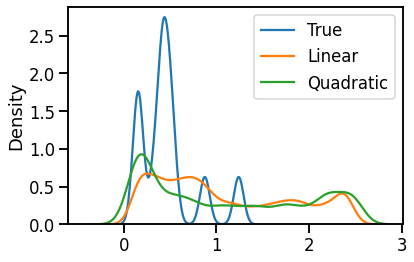

In [292]:
sns.kdeplot(rothC.xi, label='True')
sns.kdeplot(_x, label='Linear')
sns.kdeplot(xi_func(rothC._t), label='Quadratic')
plt.legend()

In [175]:
local = {}
C = rothC.C0
for t in rothC._t[:200]:
    local[t]=C[3]
    C = rothC.dCdt(C=C,t=t)

In [176]:
max(rothC.xi)

2.4509640020568617

In [114]:
max(rothC.xi)

2.4509640020568617

In [291]:
print("Min Xi", min(rothC.xi))
print("Max Xi", max(rothC.xi))


print("Min f(Xi)", min(rothC._current_XI))
print("Max f(Xi)", max(rothC._current_XI))

Min Xi 0.12804813599300677
Max Xi 1.2403193961765784
Min f(Xi) 0.09173583287822107
Max f(Xi) 1.2399467917226774


In [288]:
import seaborn as sns
sns.set_context('talk')

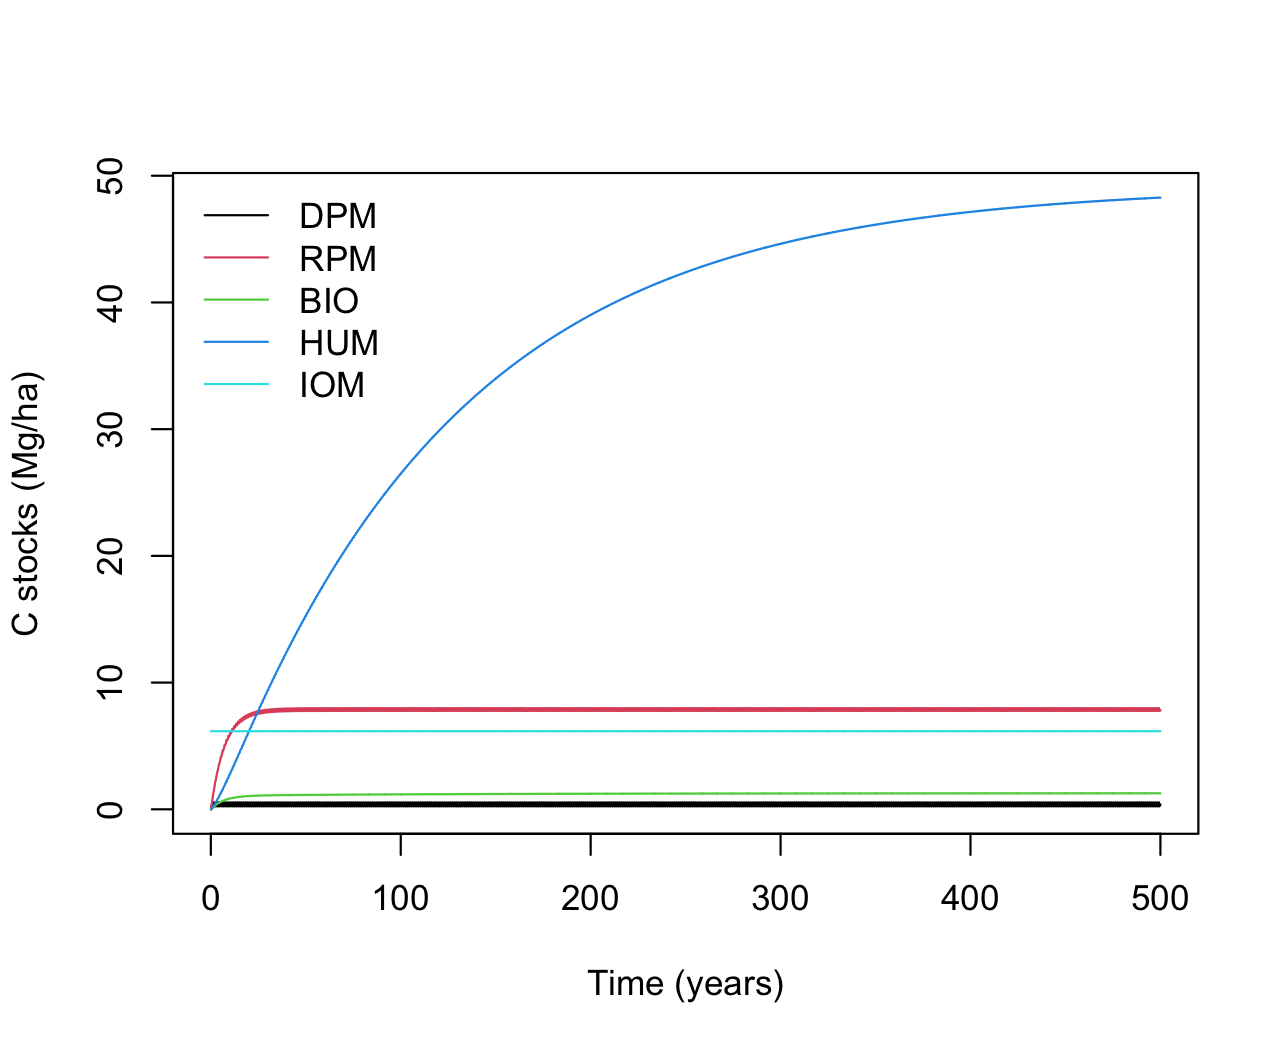

## End